# Using Census APIs for Equity Analysis

This workshop will demonstrate how to use US Decennial Census and American Community Survey Data (ACS) Application Programming Interfaces (APIs). We will use these basic operations in order to calculate and map ethnicity, gender, mobility, poverty rates and journey to work in New York City. We will pull data from the [ACS 5-year estimates for 2020](https://www.census.gov/data/developers/data-sets/acs-5year.html) for this workshop.

Prerequisites:
1. Anaconda 3 installed
2. Knowledge of Jupyter Notebook
3. Knowledge of Python
4. Knowledge of how to install GeoPandas
5. Knowledge of how to perform pip installations

NOTE:  The cool thing about using APIs is, once this script is developed, the data should remain current with each use--no need to update the links to the API!

## Step 1: Import the modules you will need

If you don't have geopandas installed, then the code below will not run:

For help, try this article: ["Fastest way to install Geopandas in jupyter notebook on Windows"](https://medium.com/analytics-vidhya/fastest-way-to-install-geopandas-in-jupyter-notebook-on-windows-8f734e11fa2b), by Tanish Gupta

If that doesn't work, then try installing python 3.9 and creating a new virtual environment in the Anaconda prompt:

1. Type in “conda create –name py39 python=3.9” in the Anaconda Prompt and hit enter. Py39 is the virtual environment name. 
2. If that works, then type in “activate py39” and press Enter. 
3. Then type in “conda install geopandas” and hit enter. 

Also, you will need to perform a pip install census and us

And make sure you have the latest shapely library installed.  If not, you will need to upgrade it (>conda install shapely)

In [18]:
#import modules
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
from census import Census
from us import states
import fiona
from github.MainClass import Github, GithubIntegration
from github.InputGitTreeElement import InputGitTreeElement

In [2]:
# fiona.supported_drivers -- if you want to see a list of all spatial data types that are supported, just remove the hashtag

In [3]:
# pip install PyGithub

## Step 2: Import data from Census

Let’s begin by accessing and importing census data. Importing census data into Python requires a Census API key. A key can be obtained from Census API Key. It will provide you with a unique 40 digit text string. Please keep track of this number. Store it in a safe place.

NOTE: Keep your API key private!  I used mine to test my script, but I've removed it from below.

# NOTE: demonstrate to how to get an API key--maybe include some images?

Census API User Guide
https://www.census.gov/content/dam/Census/data/developers/api-user-guide/api-guide.pdf

In [19]:
# Set API key
c = Census("042c838cf64a6632939838ab9c941796aaa2779f")

With the Census API key set, we will access the census data at the tract level for New York City from the 2020 ACS, specifically the ratio of income to poverty in the past 12 months (C17002_001E, total; C17002_002E, < 0.50; and C17002_003E, 0.50 - 0.99) variables and the total population (B01003_001E) variable. For more information on why these variables are used, refer to the US Census Bureau’s article on how the Census Bureau measures poverty and the list of variables found in ACS.

The census package provides us with some easy convenience methods that allow us to obtain data for a wide variety of geographies. The FIPS code for Virginia is 51, but if needed, we can also use the us library to help us figure out the relevant FIPS code.

# NOTE: Include a way for others to locate the tables that you used for this---maybe a demo of how to use the Census ACS site?

In [20]:
# Obtain Census variables from the 2020 ACS at the tract level for the State of New York (FIPS code: 36)
# C17002_001E: count of ratio of income to poverty in the past 12 months (total)
# C17002_002E: count of ratio of income to poverty in the past 12 months (< 0.50)
# C17002_003E: count of ratio of income to poverty in the past 12 months (0.50 - 0.99)
# B01003_001E: total population
# Sources: https://api.census.gov/data/2019/acs/acs5/variables.html; https://pypi.org/project/census/
ny_census = c.acs5.state_county_tract(fields = ('NAME', 'C17002_001E', 'C17002_002E', 'C17002_003E', 'B01003_001E'),
                                      state_fips = states.NY.fips,
                                      county_fips = "*",
                                      tract = "*",
                                      year = 2019)

Now that we have accessed the data and assigned it to a variable, we can read the data into a dataframe using the pandas library.

In [21]:
# Create a dataframe from the census data
ny_df = pd.DataFrame(ny_census)

# Show the dataframe
print(ny_df.head(2))
print('Shape: ', ny_df.shape)

                                            NAME  C17002_001E  C17002_002E  \
0     Census Tract 55, Onondaga County, New York       3542.0        912.0   
1  Census Tract 56.01, Onondaga County, New York       1569.0         71.0   

   C17002_003E  B01003_001E state county   tract  
0        400.0       3563.0    36    067  005500  
1         46.0       1599.0    36    067  005601  
Shape:  (4918, 8)


### By showing the dataframe, we can see that there are 4918 rows (i.e. 4918 census tracts) and 8 columns.

# Import Shapefile

Let’s also read into Python a 2019 shapefile of the New York census tracts and reproject it to the UTM Zone 18N (also known as EPSG 32618) projection. (This shapefile can be downloaded on the Census Bureau’s website on the [Cartographic Boundary Files page](https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html) or the [TIGER/Line Shapefiles page](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html).)

In [22]:
# Access shapefile of New York census tracts
ny_tract = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_36_tract.zip")

# Reproject shapefile to UTM Zone 18N
# https://spatialreference.org/ref/epsg/wgs-84-utm-zone-18n/
ny_tract = ny_tract.to_crs(epsg = 32618)

# Print GeoDataFrame of shapefile
print(ny_tract.head(2))
print('Shape: ', ny_tract.shape)

# Check shapefile projection
print("\nThe shapefile projection is: {}".format(ny_tract.crs))

  STATEFP COUNTYFP TRACTCE        GEOID NAME          NAMELSAD  MTFCC  \
0      36      081  044800  36081044800  448  Census Tract 448  G5020   
1      36      081  045800  36081045800  458  Census Tract 458  G5020   

  FUNCSTAT   ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S  208002       0  +40.7110219  -073.8026344   
1        S  245281       0  +40.7152626  -073.7909261   

                                            geometry  
0  POLYGON ((600815.465 4507478.308, 600891.234 4...  
1  POLYGON ((601895.758 4507688.811, 601896.787 4...  
Shape:  (4918, 13)

The shapefile projection is: epsg:32618


By printing the shapefile, we can see that the shapefile also has 4918 rows (4918 tracts). This number matches with the number of census records that we have on file.

Not so fast, though. We have a potential problem: We have the census data, and we have the shapefile of census tracts that correspond with that data, but they are stored in two separate variables (va_df and va_tract respectively)! That makes it a bit difficult to map since these two separate datasets aren’t connected to each other.

# Performing Dataframe Operations

Create new column from old columns to get combined FIPS code
To solve this problem, we can join the two dataframes together via a field or column that is common to both dataframes, which is referred to as a key.

Looking at the two datasets above, it appears that the GEOID column from ny_tract and the state, county, and tract columns combined from ny_df could serve as the unique key for joining these two dataframes together. In their current forms, this join will not be successful, as we’ll need to merge the state, county, and tract columns from ny_df together to make it parallel to the GEOID column from ny_tract. We can simply add the columns together, much like math or the basic operators in Python, and assign the “sum” to a new column.

To create a new column–or call an existing column in a dataframe–we can use indexing with [] and the column name (string). (There is a different way if you want to access columns using the index number; read more about indexing and selecting data [in the pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html).)

In [23]:
# Combine state, county, and tract columns together to create a new string and assign to new column
ny_df["GEOID"] = ny_df["state"] + ny_df["county"] + ny_df["tract"]

Printing out the first rew rows of the dataframe, we can see that the new column GEOID has been created with the values from the three columns combined.

In [24]:
# Print head of dataframe
ny_df.head(2)

,NAME,C17002_001E,C17002_002E,C17002_003E,B01003_001E,state,county,tract,GEOID
0,"Census Tract 55, Onondaga County, New York",3542.0,912.0,400.0,3563.0,36,067,005500,36067005500
1,"Census Tract 56.01, Onondaga County, New York",1569.0,71.0,46.0,1599.0,36,067,005601,36067005601


# Remove dataframe columns that are no longer needed

To reduce clutter, we can delete the state, county, and tract columns from ny_df since we don’t need them anymore. Remember that when we want to modify a dataframe, we must assign the modified dataframe back to the original variable (or a new one, if preferred). Otherwise, any modifications won’t be saved. An alternative to assigning the dataframe back to the variable is to simply pass inplace = True. For more information, see the [pandas help documentation on drop](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html).

In [25]:
# Remove columns
ny_df = ny_df.drop(columns = ["state", "county", "tract"])

# Show updated dataframe
ny_df.head(2)

,NAME,C17002_001E,C17002_002E,C17002_003E,B01003_001E,GEOID
0,"Census Tract 55, Onondaga County, New York",3542.0,912.0,400.0,3563.0,36067005500
1,"Census Tract 56.01, Onondaga County, New York",1569.0,71.0,46.0,1599.0,36067005601


# Check column data types

The key in both dataframe must be of the same data type. Let’s check the data type of the GEOID columns in both dataframes. If they aren’t the same, we will have to change the data type of columns to make them the same.

In [26]:
# Check column data types for census data
print("Column data types for census data:\n{}".format(ny_df.dtypes))

# Check column data types for census shapefile
print("\nColumn data types for census shapefile:\n{}".format(ny_tract.dtypes))

# Source: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html

Column data types for census data:
NAME            object
C17002_001E    float64
C17002_002E    float64
C17002_003E    float64
B01003_001E    float64
GEOID           object
dtype: object

Column data types for census shapefile:
STATEFP       object
COUNTYFP      object
TRACTCE       object
GEOID         object
NAME          object
NAMELSAD      object
MTFCC         object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object


Looks like the GEOID columns are the same!

# Merge dataframes

Now, we are ready to merge the two dataframes together, using the GEOID columns as the primary key. We can use the merge method in GeoPandas called on the ny_tract shapefile dataset.

In [27]:
# Join the attributes of the dataframes together
# Source: https://geopandas.org/docs/user_guide/mergingdata.html
ny_merge = ny_tract.merge(ny_df, on = "GEOID")

# Show result
print(ny_merge.head(2))
print('Shape: ', ny_merge.shape)

  STATEFP COUNTYFP TRACTCE        GEOID NAME_x          NAMELSAD  MTFCC  \
0      36      081  044800  36081044800    448  Census Tract 448  G5020   
1      36      081  045800  36081045800    458  Census Tract 458  G5020   

  FUNCSTAT   ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S  208002       0  +40.7110219  -073.8026344   
1        S  245281       0  +40.7152626  -073.7909261   

                                            geometry  \
0  POLYGON ((600815.465 4507478.308, 600891.234 4...   
1  POLYGON ((601895.758 4507688.811, 601896.787 4...   

                                      NAME_y  C17002_001E  C17002_002E  \
0  Census Tract 448, Queens County, New York       2796.0         49.0   
1  Census Tract 458, Queens County, New York       2348.0         59.0   

   C17002_003E  B01003_001E  
0        696.0       2809.0  
1         70.0       2348.0  
Shape:  (4918, 18)


Success! We still have 4918 rows, which means that all rows (or most of them) were successfully matched! Notice how the census data has been added on after the shapefile data in the dataframe.

Some additional notes about joining dataframes:

- the columns for the key do not need to have the same name.
- for this join, we had a one-to-one relationship, meaning one attribute in one dataframe matched to one (and only one) attribute in the other dataframe. Joins with a many-to-one, one-to-many, or many-to-many relationship are also possible, but in some cases, they require some special considerations. See this Esri ArcGIS help documentation on joins and relates for more information.

# Subset dataframe

Now that we merged the dataframes together, we can further clean up the dataframe and remove columns that are not needed. Instead of using the drop method, we can simply select the columns we want to keep and create a new dataframe with those selected columns.

In [28]:
# Create new dataframe from select columns
ny_poverty_tract = ny_merge[["STATEFP", "COUNTYFP", "TRACTCE", "GEOID", "geometry", "C17002_001E", "C17002_002E", "C17002_003E", "B01003_001E"]]

# Show dataframe
print(ny_poverty_tract.head(2))
print('Shape: ', ny_poverty_tract.shape)

  STATEFP COUNTYFP TRACTCE        GEOID  \
0      36      081  044800  36081044800   
1      36      081  045800  36081045800   

                                            geometry  C17002_001E  \
0  POLYGON ((600815.465 4507478.308, 600891.234 4...       2796.0   
1  POLYGON ((601895.758 4507688.811, 601896.787 4...       2348.0   

   C17002_002E  C17002_003E  B01003_001E  
0         49.0        696.0       2809.0  
1         59.0         70.0       2348.0  
Shape:  (4918, 9)


Notice how the number of columns dropped from 18 to 9.

# Dissolve geometries and get summarized statistics to get poverty statistics at the county level

Next, we will group all the census tracts within the same county (COUNTYFP) and aggregate the poverty and population values for those tracts within the same county. We can use the dissolve function in GeoPandas, which is the spatial version of groupby in pandas. We use dissolve instead of groupby because the former also groups and merges all the geometries (in this case, census tracts) within a given group (in this case, counties).

In [29]:
# Dissolve and group the census tracts within each county and aggregate all the values together
# Source: https://geopandas.org/docs/user_guide/aggregation_with_dissolve.html
ny_poverty_county = ny_poverty_tract.dissolve(by = 'COUNTYFP', aggfunc = 'sum')

# Show dataframe
print(ny_poverty_county.head(2))
print('Shape: ', ny_poverty_county.shape)

                                                   geometry  C17002_001E  \
COUNTYFP                                                                   
001       POLYGON ((560480.589 4696656.581, 560491.195 4...     291149.0   
003       POLYGON ((274228.780 4683036.881, 274189.135 4...      41742.0   

          C17002_002E  C17002_003E  B01003_001E  
COUNTYFP                                         
001           17954.0      16616.0     306968.0  
003            2752.0       4295.0      46688.0  
Shape:  (62, 5)


Notice that we got the number of rows down from 4918 to 62.

# Perform column math to get poverty rates

We can estimate the poverty rate by dividing the sum of C17002_002E (ratio of income to poverty in the past 12 months, < 0.50) and C17002_003E (ratio of income to poverty in the past 12 months, 0.50 - 0.99) by B01003_001E (total population).

Side note: Notice that C17002_001E (ratio of income to poverty in the past 12 months, total), which theoretically should count everyone, does not exactly match up with B01003_001E (total population). We’ll disregard this for now since the difference is not too significant.

In [30]:
# Get poverty rate and store values in new column
ny_poverty_county["Poverty_Rate"] = (ny_poverty_county["C17002_002E"] + ny_poverty_county["C17002_003E"]) / ny_poverty_county["B01003_001E"] * 100

# Show dataframe
ny_poverty_county.head(2)

,geometry,C17002_001E,C17002_002E,C17002_003E,B01003_001E,Poverty_Rate
COUNTYFP,,,,,,
001,"POLYGON ((560480.589 4696656.581, 560491.195 4...",291149.0,17954.0,16616.0,306968.0,11.261760
003,"POLYGON ((274228.780 4683036.881, 274189.135 4...",41742.0,2752.0,4295.0,46688.0,15.093814


# Plotting Results

Finally, since we have the spatial component connected to our census data, we can plot the results!

Text(0.5, 1.0, 'Poverty Rates (%) in New York State')

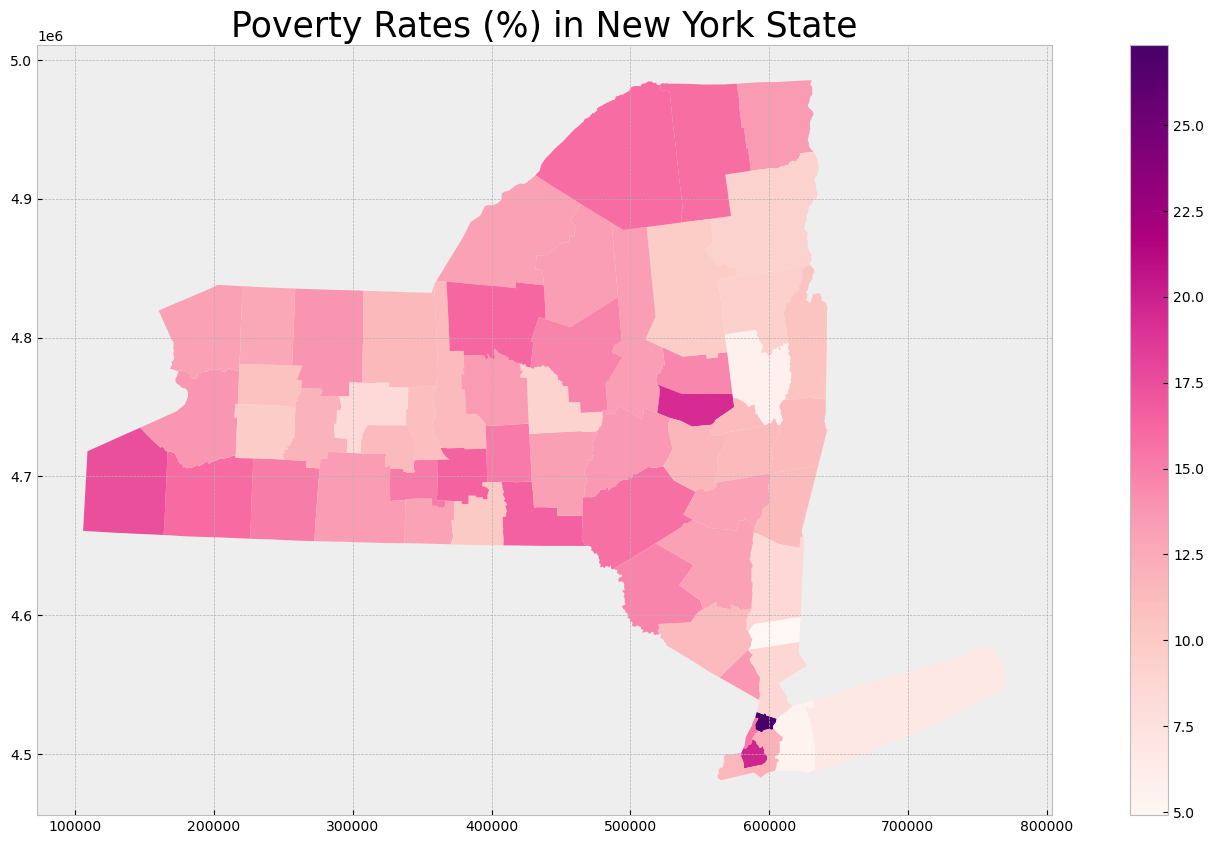

In [31]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (20, 10))

# Plot data
# Source: https://geopandas.readthedocs.io/en/latest/docs/user_guide/mapping.html
ny_poverty_county.plot(column = "Poverty_Rate",
                       ax = ax,
                       cmap = "RdPu",
                       legend = True)

# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('Poverty Rates (%) in New York State', fontdict = {'fontsize': '25', 'fontweight' : '3'})

In [32]:
# Create a output path for the data
# outfp = r'‪C:\Users\mromano1\Downloads\Poverty_Rates_in_NYS_2019.shp'

# Write data to shapefile
ny_poverty_county.to_file(r"\\dotfp\40Worth_DatafilesII\Administrative_Guide\PMA\Maddalena Romano\Poverty Rates in NYS 2019 v2.shp",encoding='utf-8')

C:\Users\mromano1\AppData\Local\Temp\ipykernel_19592\3508427761.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ny_poverty_county.to_file(r"\\dotfp\40Worth_DatafilesII\Administrative_Guide\PMA\Maddalena Romano\Poverty Rates in NYS 2019 v2.shp",encoding='utf-8')
